# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [14:43:16.611] [74253] 151 logging_/<module>: {logging_yaml: None}

INFO     [14:43:17.200] [74253]  36 api.server_globals/init

DEBUG    [14:43:17.211] [74253]  84 api.server_globals/load: load_search...

INFO     [14:43:17.617] [74253]  88 api.server_globals/load: load_search (took 0.396s)

DEBUG    [14:43:17.625] [74253]  84 api.server_globals/load: load_xc_meta...

INFO     [14:43:18.172] [74253]  88 api.server_globals/load: load_xc_meta (took 0.538s)

DEBUG    [14:43:18.180] [74253]  84 api.server_globals/load: load_feat_info...

INFO     [14:43:18.189] [74253] 120 api.server_globals/load_feat_info

INFO     [14:43:18.197] [74253]  88 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [14:43:18.205] [74253]  82 api.server_globals/load: load_search_recs [skipped]

INFO     [14:43:18.214] [74253]  38 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

In [ ]:
# Fail if too few recs are downloaded (easy way to waste a bunch of training time!)
sg_load.load_xc_meta(_nocache=True,
    fail_on_low_download_frac=True,
);

INFO     [14:43:18.419] [74253] 104 api.server_globals/load_xc_meta

all              9442/399859 (sp/recs)

countries         1148/59713 (sp/recs)

species            334/35237 (sp/recs)

(downloaded)       334/35233 (sp/recs)

 99.99%

recs_at_least      334/35233 (sp/recs)

num_species        334/35233 (sp/recs)

num_recs           334/35233 (sp/recs)

recs ≥ 2           334/35233 (sp/recs)

search_recs(**{'cache_type': 'hybrid'})

INFO     [14:43:25.056] [74253] 602 api.recs/get_search_recs

INFO     [14:43:25.069] [74253] 152 payloads/df_cache_hybrid: Hit: payloads/search_recs-audio_s[10],version[8],com_names_k[ca],countries_k[na],num_recs[None]-c292d6b

INFO     [14:43:27.352] [74253] 169 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (51.0 MB) [2.262s]

INFO     [14:43:38.248] [74253] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (1.4 GB) [10.872s]

INFO     [14:43:39.184] [74253] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (382.8 MB) [0.858s]

INFO     [14:43:39.232] [74253] 188 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (46.6 MB) [float32, 0.036s]

INFO     [14:43:39.394] [74253] 188 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (211.4 MB) [float32, 0.150s]

INFO     [14:43:39.401] [74253] 191 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [14:43:39.861] [74253] 202 payloads/df_cache_hybrid: Hit [14.778s]

INFO     [14:43:41.539] [74253] 247 payloads/df_cache_hybrid: Mobile: Add columns for mobile [1.658s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (334) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.9s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: audio_bytes: [

#########                                                   

] |  16% (35231) |  1.5s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  1.6s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  1.7s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  1.8s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  1.9s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.0s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.2s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.3s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.4s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.5s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.6s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  2.7s

Mobile: Write files: audio_bytes: [

###################                                         

] |  32% (35231) |  2.8s

Mobile: Write files: audio_bytes: [

#####################                                       

] |  35% (35231) |  2.9s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.0s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.2s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.3s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.4s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.5s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.6s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.7s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.8s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  3.9s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  4.0s

Mobile: Write files: audio_bytes: [

###########################                                 

] |  45% (35231) |  4.1s

Mobile: Write files: audio_bytes: [

############################                                

] |  47% (35231) |  4.2s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  4.4s

Mobile: Write files: audio_bytes: [

##################################                          

] |  57% (35231) |  4.5s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  4.6s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  4.7s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  4.8s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  4.9s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  5.0s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  5.1s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  5.2s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  5.3s

Mobile: Write files: audio_bytes: [

#####################################                       

] |  62% (35231) |  5.5s

Mobile: Write files: audio_bytes: [

#######################################                     

] |  65% (35231) |  5.6s

Mobile: Write files: audio_bytes: [

##########################################                  

] |  70% (35231) |  5.7s

Mobile: Write files: audio_bytes: [

#############################################               

] |  75% (35231) |  5.8s

Mobile: Write files: audio_bytes: [

#############################################               

] |  75% (35231) |  5.9s

Mobile: Write files: audio_bytes: [

#############################################               

] |  75% (35231) |  6.0s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) |  6.1s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.2s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.3s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.4s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.5s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.7s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.8s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  6.9s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  7.0s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  7.1s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  7.2s

Mobile: Write files: audio_bytes: [

#################################################           

] |  82% (35231) |  7.3s

Mobile: Write files: audio_bytes: [

############################################################

] | 100% (35231) |  7.4s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (334) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.9s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: spectro_bytes: [

#                                                         

] |   2% (35231) |  1.5s

Mobile: Write files: spectro_bytes: [

###                                                       

] |   6% (35231) |  1.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.0s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.1s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.9s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.1s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.2s

Mobile: Write files: spectro_bytes: [

#############                                             

] |  22% (35231) |  3.3s

Mobile: Write files: spectro_bytes: [

####################                                      

] |  35% (35231) |  3.4s

Mobile: Write files: spectro_bytes: [

#####################                                     

] |  37% (35231) |  3.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.7s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.8s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.9s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.3s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.4s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.7s

Mobile: Write files: spectro_bytes: [

#############################                             

] |  50% (35231) |  4.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  4.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.5s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.2s

Mobile: Write files: spectro_bytes: [

#######################################                   

] |  67% (35231) |  6.3s

Mobile: Write files: spectro_bytes: [

############################################              

] |  77% (35231) |  6.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.6s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.7s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  6.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.3s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.6s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.7s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.2s

Mobile: Write files: spectro_bytes: [

#################################################         

] |  85% (35231) |  8.3s

Mobile: Write files: spectro_bytes: [

##########################################################

] | 100% (35231) |  8.4s

INFO     [14:44:21.618] [74253] 289 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [6.739s]

INFO     [14:44:22.056] [74253] 301 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.423s]

INFO     [14:44:22.472] [74253] 332 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (35231) [0.178s]

INFO     [14:44:22.660] [74253] 332 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (35231) [0.173s]

INFO     [14:44:46.043] [74253] 354 payloads/df_cache_hybrid: Mobile: Create table search_recs [166.2 MB, 23.284s]

INFO     [14:44:46.244] [74253] 390 payloads/df_cache_hybrid: Mobile: Create index (source_id) [602.1 kB, 0.186s]

INFO     [14:44:46.449] [74253] 390 payloads/df_cache_hybrid: Mobile: Create index (species, source_id) [786.4 kB, 0.191s]

INFO     [14:44:46.708] [74253] 390 payloads/df_cache_hybrid: Mobile: Create index (species, species_species_group, quality, source_id) [1.6 MB, 0.247s]

INFO     [14:44:46.963] [74253] 390 payloads/df_cache_hybrid: Mobile: Create index (species_species_group, species, quality, source_id) [1.6 MB, 0.231s]

INFO     [14:44:47.176] [74253] 393 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/search_recs.sqlite3 [170.7 MB, 24.432s]

INFO     [14:44:47.190] [74253] 402 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/server-config.json [2.3 kB, 0.001s]

INFO     [14:44:47.250] [74253] 422 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/metadata/species.json [149.8 kB, 0.049s]

INFO     [14:44:47.341] [74253] 449 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/metadata/xc_ids.json [699.4 kB, 0.078s]

INFO     [14:44:47.364] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.003s]

INFO     [14:44:47.380] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [14:44:47.392] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [14:44:47.404] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.001s]

INFO     [14:44:47.442] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._coef_arr.npy [4.0 MB, 0.009s]

INFO     [14:44:47.461] [74253] 470 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._intercept_arr.npy [2.8 kB, 0.001s]

INFO     [14:44:47.470] [74253] 524 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/models/search.json [4.9 kB, 0.115s]

INFO     [14:44:47.477] [74253] 524 payloads/df_cache_hybrid: Mobile: Write payload [67.602s]

,dir,file,size,frac
5,api,TOTAL,2104303182,1.000
1,api,api/bytes-audio_bytes.parquet,1412454635,0.671
2,api,api/bytes-spectro_bytes.parquet,382830165,0.182
4,api,api/feat-feat.npy: float32,211386128,0.100
0,api,api/lite.parquet,50986282,0.024
3,api,api/feat-f_preds.npy: float32,46645972,0.022
9,mobile-version[2],TOTAL,2123022336,1.000
6,mobile-version[2],mobile-version[2]/search_recs/audio/,1502609408,0.708
7,mobile-version[2],mobile-version[2]/search_recs/spectro/,449687552,0.212
8,mobile-version[2],mobile-version[2]/search_recs/search_recs.sqlite3,170725376,0.080


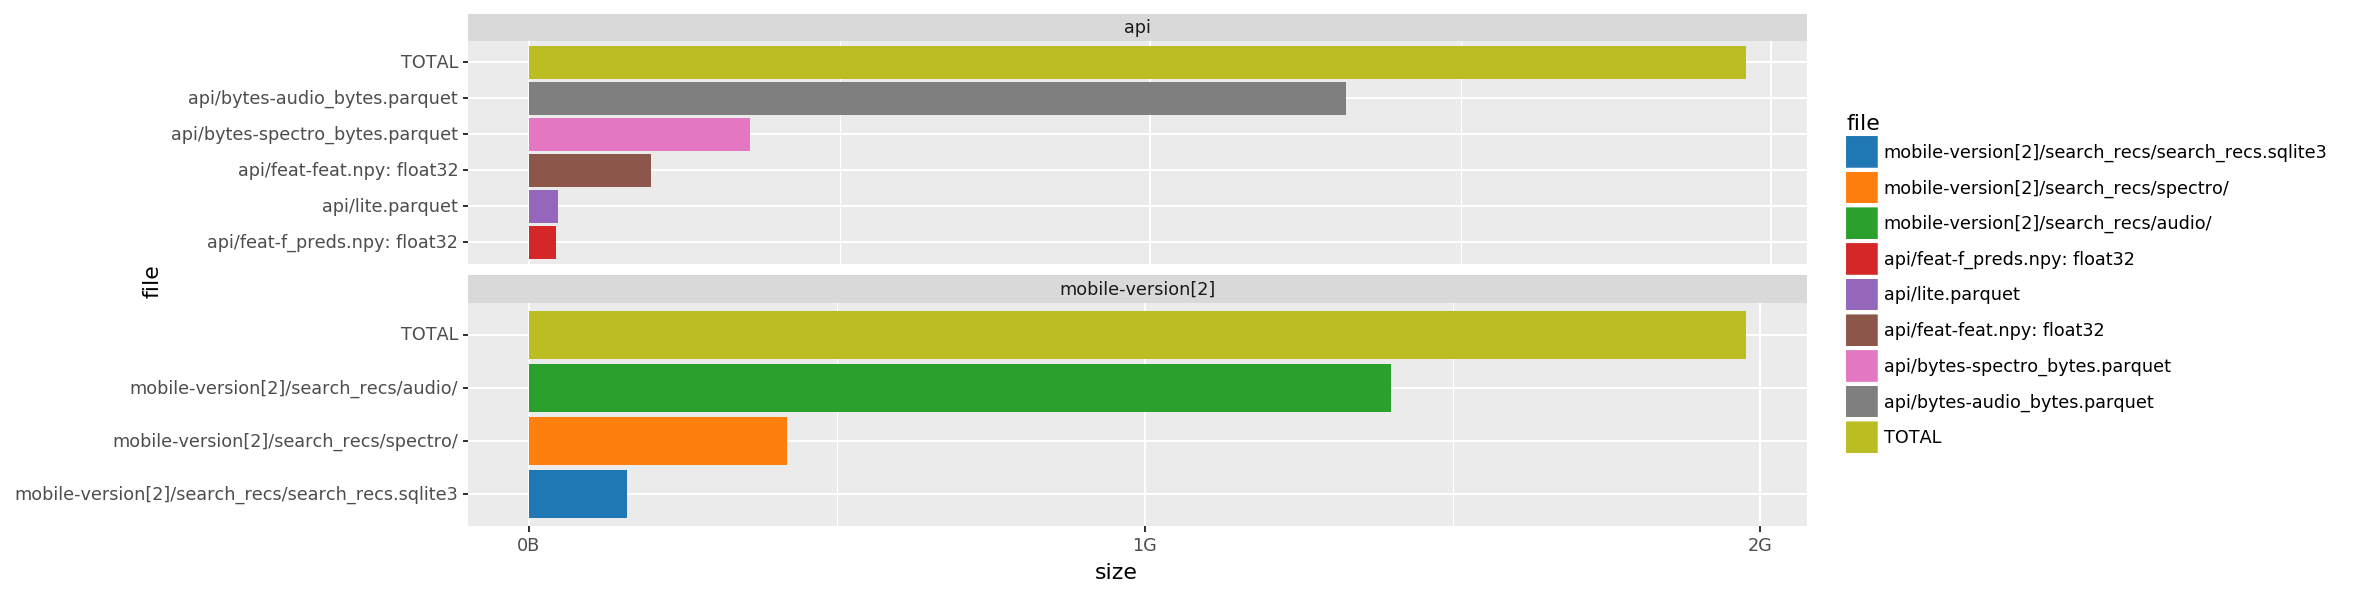

<ggplot: (364544993)>

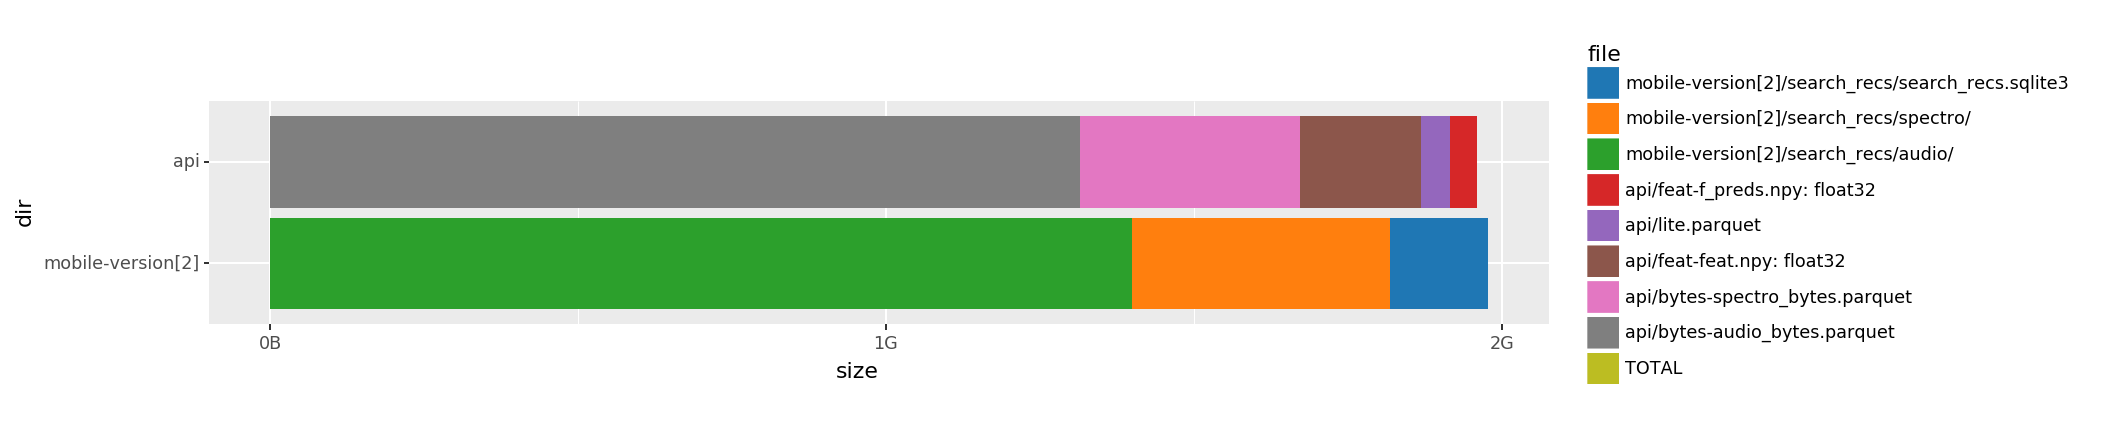

<ggplot: (-9223372036490233477)>

,size,type,0
xc_id,36,int,413174
feat,104,ndarray,[ 9.373e-02 -4.262e-02 4.967e-01 1.976e-03 -5.053e-02 -5.996e-02 4.511e-02 -1.633e-01 6.422e-02 -2.063e-02 -7.629e-02 -8.226e-02 -9.336e-02 5.237e-02 -4.327e-02 -7.05...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
with ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # XXX Debug
    log_levels({
        'payloads': 'INFO',
        # 'payloads': 'DEBUG',
    })
    kwargss = [
        # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss [XXX Debug]
        dict(cache_type='hybrid'),                  # Allow cache hit
    ]
    search_recss = []
    for i, kwargs in enumerate(kwargss):
        if i > 0: print()
        print(f'search_recs(**{kwargs})')
        get_search_recs.cache_clear()
        search_recs = get_search_recs(**kwargs,
            write_mobile_payload=True,
            plot_sizes=True,
        )
        search_recss.append(search_recs)
        display(search_recs
            [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
            [2:3].reset_index(drop=True).T
            .pipe(df_assign_first,
                size=lambda df: df.T.memory_usage(deep=True),
                type=lambda df: df[0].map(lambda x: type(x).__name__),
            )
        )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]